In [ ]:
#@title 
import random
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(2018)
np.random.RandomState(2018)
random.seed(2018)

  


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


## Dataset : CEDAR Buffalo

For this project we will be using the CEDAR Signature verification dataset. 
- CEDAR signature database
contains signatures of **55 signers** belonging to various cultural and professional backgrounds.
  - Each of these signers signed **24 genuine signatures 20 minutes apart.**
- Each of the forgers tried to emulate the signatures of 3 persons, 8 times each, to produce **24 forged signatures** for each of the genuine signers. Hence the dataset comprise 55 × 24 = 1, 320 genuine signatures as well as 1, 320 forged signatures. 
- The signature images in this dataset are available in
gray scale mode.



In [ ]:
!ls signatures

full_forg  full_org  Readme.txt


In [ ]:
img_base_path = "signatures/"
forg_list = os.listdir("signatures/full_forg")
orig_list = os.listdir("signatures/full_org")
forg_list.sort()
len(forg_list)
forg_list.remove("Thumbs.db")
orig_list.remove("Thumbs.db")
forg_list[:2], orig_list[:2]

(['forgeries_10_1.png', 'forgeries_10_10.png'],
 ['original_22_17.png', 'original_43_7.png'])

### Load images from array


In [ ]:
# load images from the signature folder
def get_image_array(folder_type):
    img_holder = []

    for i in range(1,56):
        for j in range(1,25):
            f_path = "signatures/" + folder_type + str(i) + "_" + str(j) + ".png"
            img_np = load_img(f_path, target_size=(128,128), color_mode="grayscale")
            img_np = np.squeeze(img_to_array(img_np))  # convert to image np array?
            img_holder.append(img_np)
    return img_holder
    
forg_imgs = get_image_array("full_forg/forgeries_")
orig_imgs = get_image_array("full_org/original_")

print("Number of original images", len(orig_imgs), orig_imgs[0].shape)
print("Number of forged images", len(forg_imgs))

Number of original images 1320 (128, 128)
Number of forged images 1320


## Visualize the forgeries and originals

- One thing to notice immediately is that both images have different backgrounds. 
- This might introduce additional noise to the process and confuse the model i.e. use background information
for weighting distance metric.
- May be a good idea to **apply from tranforms** to the data before training.
                                                                            

<Figure size 1152x216 with 0 Axes>

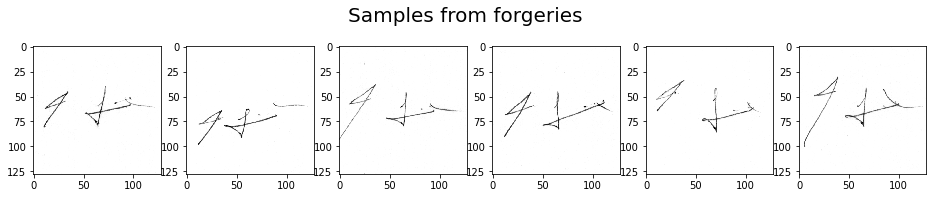

<Figure size 1152x216 with 0 Axes>

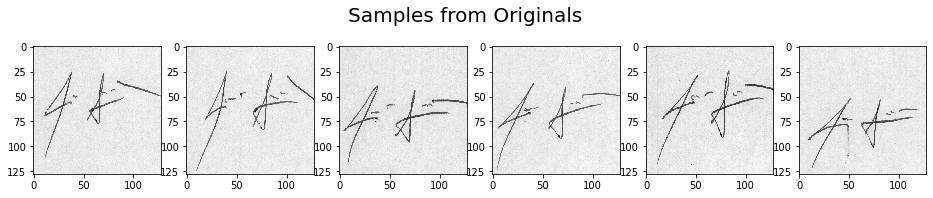

In [ ]:
import matplotlib.pyplot as plt  


def visualize_images(img_array, fig_title):
    plt.rcParams['figure.figsize'] = (16,3)
    plt.figure()
    f, axs = plt.subplots(1, 6)
    for i, ax in enumerate(axs): 
        ax.imshow(img_array[i] , cmap='gray' )
    f.suptitle(fig_title, fontsize=20)
        
visualize_images(forg_imgs, "Samples from forgeries")
visualize_images(orig_imgs, "Samples from Originals")
        
#     ax[i*1].imshow(img[:,:,1], cmap='gray', interpolation='none')

## Constructing Training Data

We want to train the model such that it learns to distinguish subtle differences between the signatures and forgeries which are already similar. We also want to distinguish between different signatures which are dissimilar

### Negatives
- Soft [PN] For each original, construct an original and all its forgery 
- Hard [PN, Positive, Negative] For each original, construct an original and all other forgeries 55*24

- Hard [PN, Positive, Negative] For each original, construct original and all other originals 55 * 54

- Hard [PN, Positive, Negative] For each forgery, construct forgery and all other forgery 55 * 54

### Positives
- [PP, Positive Positive] For each original construct original and all other originals for same signature - 24 * 23

- [PP, Positive Positive] For each forgery, construct a forgery and all other forgeries for same signature 24 * 23

In [ ]:


neg_hard_orig_other_forg = [] # Hard PN: Orig + forgery
for i in range(1,56):
  for j in range (1, 56):
    if i != j:
      pair = ["original_"+ str(i) + "_1.png", "forgeries_"+ str(j) + "_1.png" ]
      neg_hard_orig_other_forg.append(pair)

neg_hard_orig_other_forg[-15:]

[['original_55_1.png', 'forgeries_40_1.png'],
 ['original_55_1.png', 'forgeries_41_1.png'],
 ['original_55_1.png', 'forgeries_42_1.png'],
 ['original_55_1.png', 'forgeries_43_1.png'],
 ['original_55_1.png', 'forgeries_44_1.png'],
 ['original_55_1.png', 'forgeries_45_1.png'],
 ['original_55_1.png', 'forgeries_46_1.png'],
 ['original_55_1.png', 'forgeries_47_1.png'],
 ['original_55_1.png', 'forgeries_48_1.png'],
 ['original_55_1.png', 'forgeries_49_1.png'],
 ['original_55_1.png', 'forgeries_50_1.png'],
 ['original_55_1.png', 'forgeries_51_1.png'],
 ['original_55_1.png', 'forgeries_52_1.png'],
 ['original_55_1.png', 'forgeries_53_1.png'],
 ['original_55_1.png', 'forgeries_54_1.png']]

In [ ]:
neg_soft_orig_forg=[]

for i in range(1,56):
  for i_ in range(1,25):
    orig = "original_"+ str(i)+"_"+str(i_)+".png"
    for j in range(1,25):
      forg = "forg_" +str(i)+"_"+str(j)+".png"
      pair = [orig, forg]
      neg_soft_orig_forg.append(pair)

neg_soft_orig_forg[:60]

## Building a Similarity Metric Learning Model
A few questions possible approaches.



### Non Deep Learning Base Line
- HOG feature extraction
- LBP
We can use classical CV techniques such as HOG and LBP to extract features 
(compress with PCA) from 
each of the images and then compute some distance metric.

### Pretrained Model as Feature Extractor Base Line
- Use a pretrained model as a feature extractor
- Compute differences/distances between extracted features for actual/forgeries
- Select a threshold using some validation data and then run tests.

### Siamese Metric Approach
Based on foundations from the FaceNet paper (https://arxiv.org/pdf/1503.03832.pdf), following
requirements for a 
- Two similar images produce two embeddings so that the mathematical distance between them is small
- Two very different images produce two embeddings so that the mathematical distance between them is large
- The embedding is L2-normalized, ie each embedding is forced to be on the unit hypersphere


The siamese model should output a distance metric.

### Triplet Approach


### Unsupervised Approach
- We can learn an autoencoder (or denoising autoencoder) that learns to compress signatures. We can assume that this compression function learns salient features of a signature necessary for reconstruction. We can then use this as a feature extractor to generate a similarity score. Other options in the unsupervised domain include a VAE, VAE-GAN, GAN, etc.


## Constructing Training Data
We want to train the model such that it learns to distinguish subtle differences 
between the signatures and forgeries which are already similar. 
We also want to distinguish between different signatures which are dissimilar

- Soft [PN, Positive, Negative] For each original, construct an original and all other forgeries 55*24
- Hard [PN, Positive, Negative] For each original, construct original and all other originals 55 * 54
- Hard [PN, Positive, Negative] For each forgery, construct forgery and all other forgery 55 * 54

- [PP, Positive Positive] For each original construct  original and all other originals for same signature - 24 * 23
- [PP, Positive Positive] For each forgery, construct a forgery and all other forgeries for same signature 24 * 23



### Evaluating the Model
- For our test set, we want to compute the distance between each element pair and 
select a threshold that gets it right for PN and PP.


## Pretrained Model as Feature Extractor Base Line

- Use VGG16 (or any other model)
- Use early layer as feature extractor
- Plot histogram of mse between features for similar and dissimilar imagess

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as imageprep

INPUT_SHAPE =  (128,128,3)
K.clear_session()
model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet' )
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
def get_layer_list(model):
  layer_list = []
  for layer in model.layers: 
        layer_list.append(layer.name)
  return layer_list

def get_intermediate_model(model, layer_name):
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return intermediate_model

layer_list = get_layer_list(model)        

In [ ]:
print(layer_list)

['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [ ]:
layer_name = "block1_conv2" # use an early layer
e_model = get_intermediate_model(model, layer_name)
e_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_features(image_path, model, preprocess_input):

    image_size = 128 
    img = imageprep.load_img(image_path, target_size=(image_size, image_size))
    img = imageprep.img_to_array(img)
    img_data = preprocess_input(img)
    img_data = np.expand_dims(img_data, axis=0)

    extracted_feature = model.predict(img_data)

    del img, img_data  # free up memory
    return extracted_feature


def get_all_features(file_type, img_list):
    feature_holder = []
    for img_path in img_list:
        extracted_feature = get_features( os.path.join(img_base_path,file_type, img_path ), e_model, preprocess_input)
        extracted_feature = np.array(extracted_feature).flatten()
        feature_holder.append(extracted_feature)
#         print(extracted_feature.shape)
    return feature_holder 

In [ ]:
max_feats =24
forg_feats = get_all_features("full_forg", forg_list[:max_feats])
orig_feats = get_all_features("full_org", orig_list[:max_feats])
print("Forged features", len(forg_feats) )

Forged features 24


In [ ]:
from scipy import spatial
def compute_full_distance_matrix(feat, feat_matrix, distance_metric="cosine"):
    cosine_dist_matrix = spatial.distance.cdist(
        feat_matrix, feat, distance_metric) 
    return 1 - cosine_dist_matrix
def compute_distance_matrix(feat, feat_matrix, distance_metric="cosine"):
    cosine_dist_matrix = spatial.distance.cdist(
        feat_matrix, feat.reshape(1,-1), distance_metric).reshape(-1, 1)
    return 1 - cosine_dist_matrix

In [ ]:
distance = compute_full_distance_matrix(np.array(forg_feats), np.array(orig_feats) )

In [ ]:
distance.shape

(24, 24)

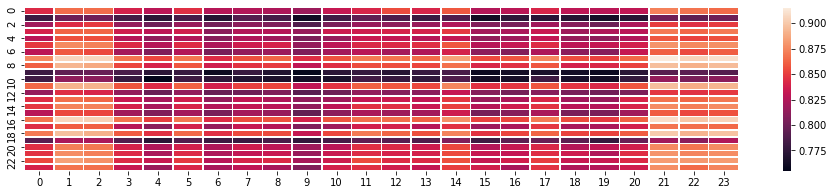

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
 
ax = sns.heatmap(distance, linewidth=0.5)
plt
plt.show()

(array([ 14.,  10.,   0.,  19.,  82., 116., 155., 109.,  45.,  26.]),
 array([0.71802074, 0.73787812, 0.75773549, 0.77759287, 0.79745025,
        0.81730763, 0.83716501, 0.85702239, 0.87687977, 0.89673714,
        0.91659452]),
 <a list of 10 Patch objects>)

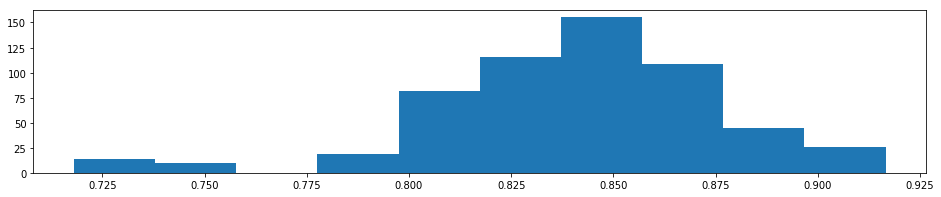

In [ ]:
import matplotlib.pyplot as plt

plt.hist(distance.reshape(-1))